# Resources

# Step 0: Overview of All the Hyperparameters for a Prophet Model

In step 0, we will provide an overview of all the hyperparameters for a prophet model. The hyperparameters are divided into three groups:

* The first group contains hyperparameters that are suitable for automatic tuning. We can specify a list of values and do a grid search for the best value combination. For more information about grid search, please refer to my previous tutorial [Hyperparameter Tuning For XGBoost](https://medium.com/grabngoinfo/hyperparameter-tuning-for-xgboost-91449869c57e)
* The second group contains hyperparameters that are suitable for manual tuning. A human needs to make a judgment on what hyperparameter value to use based on knowledge about data and business.
* The third group contains the hyperparameters that are better left untuned with the default values.

## Group 1: Hyperparameters Suitable for Automatic Tuning

There are four hyperparameters that are suitable to be tuned automatically using grid search.
* `changepoint_prior_scale` is probably the most impactful parameter according to the Prophet documentation. It determines the scale of the change at the time series trend change point. It is an L1 LASSO regularization penalty term. To learn more about regularization, please refer to my previous tutorial [LASSO (L1) Vs Ridge (L2) Vs Elastic Net Regularization For Classification Model](https://medium.com/towards-artificial-intelligence/lasso-l1-vs-ridge-l2-vs-elastic-net-regularization-for-classification-model-409c3d86f6e9)
  * When the scale is too small, the trend does not change much at the change point, and the model tends to underfit. This is because the variance caused by the trend change is likely to be considered as noise with a small `changepoint_prior_scale` value.
  * When the scale is too large, the trend changes a lot at the change point, and the model tends to overfit. The variance caused by noise is considered to be part of the trend.
  * The default value for `changepoint_prior_scale` is 0.05, and the recommended tuning range is 0.001 to 0.5. This hyperparameter is usually tuned on a log scale.

* `seasonality_prior_scale` controls the magnitude of the seasonality fluctuation. It is an L2 Ridge regularization penalty term.
  * When the scale is too small, the magnitude of the seasonality shrinks to a very small value.
  * When the scale is too large, the magnitude of the seasonality allows very large fluctuations.
  * The default value for `seasonality_prior_scale` is 10, meaning that no regularization is applied. The recommended tuning range is 0.01 to 10, where a smaller value corresponds to a smaller magnitude of seasonality. This hyperparameter is usually tuned on a log scale.

* `holidays_prior_scale` determines the scale of holiday effects, and is very similar to the `seasonality_prior_scale`. The default value is 10, meaning that no regularization is applied. The recommended tuning range is 0.01 to 10, where a smaller value corresponds to a smaller magnitude of holidays.

* `seasonality_mode` has two options, `additive` and `multiplicative`.
  * The additive model adds trend, seasonality, and other effects together when making predictions. It is appropriate for the time series models with relatively constant seasonal variation over time.
  * The multiplicative model multiplies trend, seasonality, and other effects together when making predictions. It is appropriate for the time series models with increasing or decreasing seasonal variation over time.












## Group 2: Hyperparameters Suitable for Manual Tuning

Some hyperparameters need to be evaluated by a human-based on business knowledge or data observations for manual tuning.
* `changepoint_range` is a value between 0 and 1 indicating the percentage of historical data that allow a trend change.
  * The default value is 0.8, meaning that the first 80% of the data allows trend changes, and the last 20% of the data does not allow a trend change. This is because there are not enough data at the end of the time series to identify a trend change with confidence.
  * The person who builds the model can increase or decrease the value manually by examining the time series shape and model performance for the last 20% of data.

* `growth` has two options, `linear` and `logistic`. The default value is `linear`, and it can be manually changed to `logistic` if there is a known growth saturating point.

* `changepoints` manually specifying the dates of changepoints. The default value is `None`, which allows the model to automatically identify and place the change points on the trend. However, if there are any known events such as the rebranding of the business, the corresponding date can be manually added.

* `yearly_seasonality` has three options, `auto`, `True`, and `False`. The default is `auto`, which automatically turns the yearly seasonality on when there are at least two cycles of data.
  * We can manually set `yearly_seasonality` to be `True` to force the yearly seasonality if there are less than two years of data.
  * `yearly_seasonality` is usually not set to `False`, because it's more effective to leave it on and turn down the seasonal effects by tuning `seasonality_prior_scale`[2].

* `weekly_seasonality` and `daily_seasonality` can be handled in the same way as the `yearly_seasonality`.

* `holidays` takes in a dataframe with specified holidays and special events. We can manually include or exclude holidays or events, or change the number of days impacted by the holiday to tune this hyperparameter. The magnitude of the holiday effects should be tuned by `holidays_prior_scale`.

## Group 3: Hyperparameters Suitable for No Tuning

There are five hyperparameters that should not be tuned.
* `n_changepoints` is the number of changepoints on the trend. The default value is 25. Rather than increasing or decreasing the number of changepoints, the prophet documentation[2] suggested focusing on increasing or decreasing the flexibility at those trend changes, which is done with `changepoint_prior_scale`.

* `interval_width` determines the uncertainty interval for the predictions. The default value is 0.8, meaning that the prediction upper bound `yhat_upper` and the prediction lower bound `yhat_lower` are based on the 80% uncertainty interval. `interval_width` does not impact the model prediction, so there is no need to tune this hyperparameter.

* `uncertainty_samples` is the number of samples used for uncertainty interval calculation. The default value is 1000, and increasing the value decreases the variance of the uncertainty interval. This hyperparameter does not impact the model prediction, so there is no need to tune it.

* `mcmc_samples` is an integer that determines if the model uses a full Bayesian inference or a Maximum a Posterior (MAP) for model training and prediction.
  * When it's greater than 0, a full Bayesian inference with the specified number of MCMC samples will be used. Bayesian inference usually needs at least 1000 samples to get reasonable results.
  * When it equals to 0, a Maximum a Posterior (MAP) estimation will be used. The default value for `mcmc_samples` is 0, indicating that Maximum a Posterior (MAP) estimation is used by default. The prophet documentation suggests leaving this hyperparameter unchanged[2].

* `stan_backend` needs to be specified when both `pystan` and `cmdstanpy` backends are set up. This hyperparameter does not impact model training and prediction, so there is no need to tune it.

# Step 1: Install and Import Libraries

In the first step, we will install and import libraries.

`yfinance` is the python package for pulling stock data from Yahoo Finance. `prophet` is the package for the time series model. After installing `yfinance` and `prophet`, they are imported into the notebook.

We also import `pandas` and `numpy` for data processing, `seaborn` and `matplotlib` for visualization, and `itertools`, `cross_validation`, and `performance_metrics` for hyperparameter tuning.

In [1]:
# Install libraries
!pip install yfinance prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 3.2 MB/s eta 0:00:00


In [2]:
# Data processing
import pandas as pd
import numpy as np

# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Hyperparameter tuning
import itertools
from prophet.diagnostics import cross_validation, performance_metrics

# Step 2: Pull Data

The second step pulls stock data from Yahoo Finance API. We will pull 2 years of daily data from the beginning of 2020 to the end of 2021.

* `start_date = '2020-01-02'` because January 1st is a holiday, and there is no stock data on holidays and weekends.
* `end_date = '2022-01-01'` because `yfinance` excludes the end date, so we need to add one day to the last day of the data end date.

In [3]:
# Data start date
start_date = '2020-01-02'

# Data end date
end_date = '2022-01-01' # yfinance excludes the end date, so we need to add one day to the last day of data

The goal of the time series model is to predict the closing price of Google's stock, so Google's ticker `GOOG` is used for pulling the data.

Prophet requires at least two columns as inputs: a `ds` column and a `y` column.
* The `ds` column has the time information. Currently we have the date as the index, so we reset the index and rename `date` to `ds`.
* The y column has the time series values. In this example, because we are predicting Google's closing price, the column name for the price is changed to `y`.

In [4]:
# Pull close data from Yahoo Finance for the list of tickers
ticker_list = ['GOOG']
data = yf.download(ticker_list, start=start_date, end=end_date)[['Close']]

# Change column names
data = data.reset_index()
data.columns = ['ds', 'y']

# Take a look at the data
data.head()

[*********************100%***********************]  1 of 1 completed


,ds,y
0,2020-01-02,68.368500
1,2020-01-03,68.032997
2,2020-01-06,69.710503
3,2020-01-07,69.667000
4,2020-01-08,70.216003


Using `.info`, we can see that the dataset has 505 records and there are no missing values.

In [5]:
# Data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      505 non-null    datetime64[ns]
 1   y       505 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.0 KB


Next, let's visualize the closing prices of the two tickers using `seaborn`, and add the legend to the plot using `matplotlib`. We can see that the price for Google increased a lot starting in late 2020, and almost doubled in late 2021.

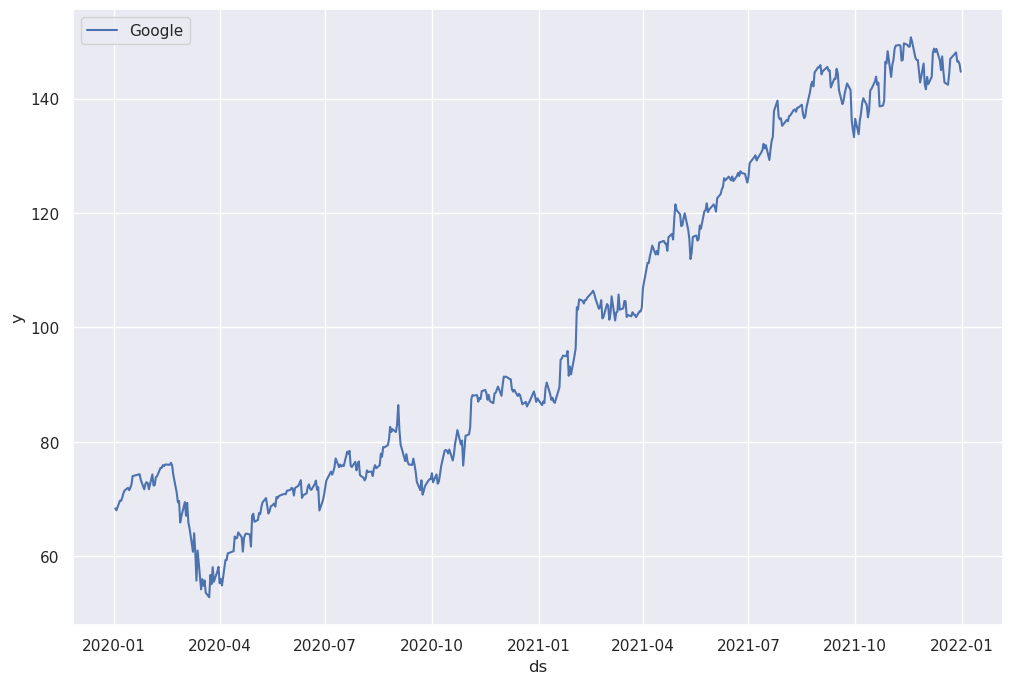

In [6]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data['ds'], y=data['y'])
plt.legend(['Google'])

# Step 3: Baseline Model Using Default Hyperparameters

In step 3, we will build a baseline model using the default prophet hyperparameters.

In [7]:
# Initiate the model
baseline_model = Prophet()

# Fit the model on the training dataset
baseline_model.fit(data)

14:47:18 - cmdstanpy - INFO - Chain [1] start processing
14:47:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet automatically fits daily, weekly, and yearly seasonalities if the time series is more than two cycles long.

The model information shows that the yearly seasonality and the daily seasonality are disabled.
* The daily seasonality is disabled because we do not have sub-daily time series.
* The yearly seasonality is disabled although we have two years of data because there are no stock price data on holidays and weekends, so we have less than 365 data points for each year.

Next, let's do cross-validation for the baseline model to get the model performance. Prophet has a `cross_validation` function to automate the comparison between the actual and the predicted values.
* `model=baseline_model` specifies the model name.
* `initial='200 days'` means the initial model will be trained on the first 200 days of data.
* `period='30 days'` means 30 days will be added to the training dataset for each additional model.
* `horizon = '30 days'` means that the model forecasts the next 30 days. When only `horizon` is given, Prophet defaults `initial` to be triple the `horizon`, and `period` to be half of the `horizon`.
* `parallel="processes"` enables parallel processing for cross-validation. When the parallel cross-validation can be done on a single machine, "processes" provide the highest performance. For larger problems, `dask` can be used to do cross-validation on multiple machines.


In [8]:
# Cross validation
baseline_model_cv = cross_validation(model=baseline_model, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")
baseline_model_cv.head()

14:47:19 - cmdstanpy - INFO - Chain [1] start processing
14:47:19 - cmdstanpy - INFO - Chain [1] start processing
14:47:19 - cmdstanpy - INFO - Chain [1] start processing
14:47:19 - cmdstanpy - INFO - Chain [1] start processing
14:47:19 - cmdstanpy - INFO - Chain [1] done processing
14:47:19 - cmdstanpy - INFO - Chain [1] done processing
14:47:19 - cmdstanpy - INFO - Chain [1] done processing
14:47:19 - cmdstanpy - INFO - Chain [1] done processing
14:47:20 - cmdstanpy - INFO - Chain [1] start processing
14:47:20 - cmdstanpy - INFO - Chain [1] start processing
14:47:20 - cmdstanpy - INFO - Chain [1] start processing
14:47:20 - cmdstanpy - INFO - Chain [1] done processing
14:47:20 - cmdstanpy - INFO - Chain [1] start processing
14:47:20 - cmdstanpy - INFO - Chain [1] done processing
14:47:20 - cmdstanpy - INFO - Chain [1] done processing
14:47:20 - cmdstanpy - INFO - Chain [1] done processing
14:47:20 - cmdstanpy - INFO - Chain [1] start processing
14:47:20 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-08-10,76.626073,74.251202,78.806528,74.805000,2020-08-08
1,2020-08-11,76.962881,74.762658,79.157516,74.015999,2020-08-08
2,2020-08-12,77.252875,75.007213,79.570183,75.331001,2020-08-08
3,2020-08-13,77.053271,74.728933,79.263686,75.922501,2020-08-08
4,2020-08-14,76.964859,74.448130,79.357034,75.386497,2020-08-08


Based on the output from the cross-validation, we can get the model performance using the method `performance_metrics`.
* The model performance metrics are calculated using a rolling window. The average performance metrics values are calculated for each value of the horizon. Since we have the horizon value of 30 days, there will be 30 average values, one for each day.
* `rolling_window` determines the window size, which is the percentage of forecasted data points to include in the calculation.
  * `rolling_window=0` computes performance metrics separately for each horizon.
  * `rolling_window=0.1` is the default value, which computes performance metrics using about 10% of the predictions in each window.
  * `rolling_window=1` computes performance metrics using all the forecasted data. We are using `rolling_window=1` in this tutorial. to get a single performance metric number.
  * `rolling_window<0` computes each data point without averaging (i.e., `MSE` will actually be a squared error with no mean)[3]

In [9]:
# Model performance metrics
baseline_model_p = performance_metrics(baseline_model_cv, rolling_window=1)
baseline_model_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,33.078194,5.751364,4.61678,0.044792,0.038125,0.044732,0.518414


Prophet provides six commonly used performance metrics:
* Mean Squared Error(MSE) sums up the squared difference between actual and prediction and is divided by the number of predictions.
* Root Mean Square Error(RMSE) takes the square root of MSE.
* Mean Absolute Error(MAE) sums up the absolute difference between actual and prediction and is divided by the number of predictions.
* Mean Absolute Percentage Error(MAPE) sums up the absolute percentage difference between actual and prediction and is divided by the number of predictions. MAPE is independent of the magnitude of data, so it can be used to compare different forecasts. But it's undefined when the actual value is zero.
* Median Absolute Percentage Error(MDAPE) is similar to MAPE. The difference is that it calculates the median instead of taking the average of the absolute percentage difference.
* Symmetric Mean Absolute Percentage Error(SMAPE) is similar to MAPE. The difference is that when calculating absolute percentage error, the denominator is the actual value for MAPE and the average of the actual and predicted value for SMAPE.

We can see that the baseline model using default hyperparameters has 4.45% Mean Absolute Percentage Error (MAPE), meaning that the predictions are 4.45% off the actual values.

In [10]:
# Get the performance metric value
baseline_model_p['mape'].values[0]

0.04479162856212335

# Step 4: Models with Manual Hyperparameter Changes

In step 4, we will check the hyperparameters for manual tuning.
* `changepoint_range` will be increased from 0.8 to 0.9 to see if there is a trend change near the end of the time series. This is because the shape of the time series seems to flatter starting around October of 2021 based on human observation.

* `growth` is kept at the default value `linear` because there is no saturating point for the stock price data.

* `changepoints` is kept at the default value is `None`, which allows the model to automatically identify and place the change points on the trend. This is because there are not any known big events that are likely to impact the Google stock prices in the time range used for the model.

* `yearly_seasonality` is kept at the automated value of `False` because we do not have more than 2 cycles of yearly data for the model training.

* `weekly_seasonality` is kept at the automated value of `True` because we have more than 2 cycles of weekly data.

* `daily_seasonality` is kept at the automated value of `False` because we do not have sub-daily data.

* `holidays` takes in a dataframe with specified holidays and special events. We can manually included two special events, COVID start and Super Bowl.

The manually changed hyperparameters will be evaluated one by one. If the change improves the model performance, we will keep the change, otherwise, we will switch back to the default values.

## Step 4.1: Change Point Range

Firstly, let's increase `changepoint_range` from 0.8 to 0.9 to see if there is a trend change near the end of the time series.

In [11]:
# Initiate the model
manual_model = Prophet(changepoint_range=0.9)

# Fit the model on the training dataset
manual_model.fit(data)

# Cross validation
manual_model_cv = cross_validation(manual_model, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")

# Model performance metrics
manual_model_p = performance_metrics(manual_model_cv, rolling_window=1)
manual_model_p['mape'].values[0]

14:47:23 - cmdstanpy - INFO - Chain [1] start processing
14:47:23 - cmdstanpy - INFO - Chain [1] done processing
14:47:23 - cmdstanpy - INFO - Chain [1] start processing
14:47:23 - cmdstanpy - INFO - Chain [1] start processing
14:47:23 - cmdstanpy - INFO - Chain [1] start processing
14:47:23 - cmdstanpy - INFO - Chain [1] start processing
14:47:24 - cmdstanpy - INFO - Chain [1] done processing
14:47:24 - cmdstanpy - INFO - Chain [1] done processing
14:47:24 - cmdstanpy - INFO - Chain [1] done processing
14:47:24 - cmdstanpy - INFO - Chain [1] done processing
14:47:24 - cmdstanpy - INFO - Chain [1] start processing
14:47:24 - cmdstanpy - INFO - Chain [1] start processing
14:47:25 - cmdstanpy - INFO - Chain [1] start processing
14:47:25 - cmdstanpy - INFO - Chain [1] start processing
14:47:25 - cmdstanpy - INFO - Chain [1] done processing
14:47:25 - cmdstanpy - INFO - Chain [1] done processing
14:47:25 - cmdstanpy - INFO - Chain [1] done processing
14:47:25 - cmdstanpy - INFO - Chain [1]

0.04967070442904054

The Mean Absolute Percentage Error (MAPE) from cross-validation is 5.13%, which is higher than the baseline model of 4.45%, indicating that we should not increase the value of `changepoint_range`.

## Step 4.2: Holidays

Next, let's create two special events: COVID start and Super Bowl.

* For the COVID start event, we set the date to be March 15th of 2020, then extend the event to 15 days before and 15 days after using `lower_window` and `upper_window` separately.

* For the Super Bowl event, we set the date in 2020 and 2021 separately, and extend the event to 7 days before and 1 day after.

Then the two events are concatenated together into one dataframe called `events`.

In [12]:
# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

# Take a look at the events data
events

,holiday,ds,lower_window,upper_window
0,COVID,2020-03-15,-15,15
0,superbowl,2020-02-02,-7,1
1,superbowl,2021-02-07,-7,1


In [13]:
# Add special events
manual_model = Prophet(holidays=events)

# Fit the model on the training dataset
manual_model.fit(data)

# Cross validation
manual_model_cv = cross_validation(manual_model, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")

# Model performance metrics
manual_model_p = performance_metrics(manual_model_cv, rolling_window=1)
manual_model_p['mape'].values[0]

14:47:28 - cmdstanpy - INFO - Chain [1] start processing
14:47:28 - cmdstanpy - INFO - Chain [1] done processing
14:47:28 - cmdstanpy - INFO - Chain [1] start processing
14:47:28 - cmdstanpy - INFO - Chain [1] start processing
14:47:28 - cmdstanpy - INFO - Chain [1] start processing
14:47:28 - cmdstanpy - INFO - Chain [1] start processing
14:47:28 - cmdstanpy - INFO - Chain [1] done processing
14:47:28 - cmdstanpy - INFO - Chain [1] done processing
14:47:28 - cmdstanpy - INFO - Chain [1] done processing
14:47:28 - cmdstanpy - INFO - Chain [1] done processing
14:47:29 - cmdstanpy - INFO - Chain [1] start processing
14:47:29 - cmdstanpy - INFO - Chain [1] start processing
14:47:29 - cmdstanpy - INFO - Chain [1] start processing
14:47:29 - cmdstanpy - INFO - Chain [1] done processing
14:47:29 - cmdstanpy - INFO - Chain [1] start processing
14:47:29 - cmdstanpy - INFO - Chain [1] done processing
14:47:30 - cmdstanpy - INFO - Chain [1] done processing
14:47:30 - cmdstanpy - INFO - Chain [1]

0.046225054629246774

After adding the special events, the Mean Absolute Percentage Error (MAPE) from cross-validation is 4.64%, which is higher than the baseline model of 4.45%, indicating that the special events are not predictive of the stock prices. Therefore, we should not include special events in the model.

# Step 5: Automatic Hyperparameter Tuning

There are four hyperparameters that are suitable to be tuned automatically using grid search: `changepoint_prior_scale`, `seasonality_prior_scale`, `holidays_prior_scale`, and `seasonality_mode`.

`holidays_prior_scale` is not applicable because there is no holiday or special events included in the model. We will use grid search to find the best values for the other three hyperparameters.

* Firstly, four values for `changepoint_prior_scale`, five values for `seasonality_prior_scale`, and two values for `seasonality_mode` are used to set up the parameter grid.
* Then, all combinations of parameters are created and saved in a variable called `all_params`.
* `mapes` is an empty list created for storing the Mean Absolute Percentage Error (MAPE) for each combination of parameters.
* After that, we loop through each parameter combination to build a time series model, and save the cross-validation performance results in the list called `mapes`.
* Finally, we get the best parameters based on the minimum value of Mean Absolute Percentage Error (MAPE), and build a new model using the best parameters.

In [14]:
# Set up parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Create a list to store MAPE values for each combination
mapes = []

# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(data)
    # Cross-validation
    df_cv = cross_validation(m, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])

# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes

# Find the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)

14:47:33 - cmdstanpy - INFO - Chain [1] start processing
14:47:33 - cmdstanpy - INFO - Chain [1] done processing
14:47:33 - cmdstanpy - INFO - Chain [1] start processing
14:47:33 - cmdstanpy - INFO - Chain [1] start processing
14:47:33 - cmdstanpy - INFO - Chain [1] start processing
14:47:33 - cmdstanpy - INFO - Chain [1] start processing
14:47:33 - cmdstanpy - INFO - Chain [1] done processing
14:47:33 - cmdstanpy - INFO - Chain [1] done processing
14:47:33 - cmdstanpy - INFO - Chain [1] done processing
14:47:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
14:47:33 - cmdstanpy - INFO - Chain [1] done processing
14:47:33 - cmdstanpy - INFO - Chain [1] start processing
14:47:34 - cmdstanpy - INFO - Chain [1] done processing
14:47:34 - cmdstanpy - INFO - Chain [1] start processing
14:47:34 - cmdstanpy - INFO - Chain [1] start processing
14:47:34 - cmdstanpy - INFO - Chain [1] start processing
14:47:34 - cmdstanpy - INFO - Chain [1] done proces

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'seasonality_mode': 'additive'}


We can see that the best parameters are `changepoint_prior_scale` equals 0.05, `seasonality_prior_scale` equals 1, and `seasonality_mode` equals `additive`.

In [15]:
# Fit the model using the best parameters
auto_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'],
                     seasonality_prior_scale=best_params['seasonality_prior_scale'],
                     seasonality_mode=best_params['seasonality_mode'])

# Fit the model on the training dataset
auto_model.fit(data)

# Cross validation
auto_model_cv = cross_validation(auto_model, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")

# Model performance metrics
auto_model_p = performance_metrics(auto_model_cv, rolling_window=1)
auto_model_p['mape'].values[0]

14:51:55 - cmdstanpy - INFO - Chain [1] start processing
14:51:55 - cmdstanpy - INFO - Chain [1] done processing
14:51:55 - cmdstanpy - INFO - Chain [1] start processing
14:51:55 - cmdstanpy - INFO - Chain [1] start processing
14:51:55 - cmdstanpy - INFO - Chain [1] start processing
14:51:55 - cmdstanpy - INFO - Chain [1] start processing
14:51:55 - cmdstanpy - INFO - Chain [1] done processing
14:51:55 - cmdstanpy - INFO - Chain [1] done processing
14:51:55 - cmdstanpy - INFO - Chain [1] done processing
14:51:55 - cmdstanpy - INFO - Chain [1] done processing
14:51:55 - cmdstanpy - INFO - Chain [1] start processing
14:51:56 - cmdstanpy - INFO - Chain [1] start processing
14:51:56 - cmdstanpy - INFO - Chain [1] start processing
14:51:56 - cmdstanpy - INFO - Chain [1] start processing
14:51:56 - cmdstanpy - INFO - Chain [1] done processing
14:51:56 - cmdstanpy - INFO - Chain [1] done processing
14:51:56 - cmdstanpy - INFO - Chain [1] done processing
14:51:56 - cmdstanpy - INFO - Chain [1]

0.0441110469264493

The Mean Absolute Percentage Error (MAPE) from cross-validation is 4.42% for the model with the best parameters, which is better than the baseline model of 4.45%.

# Step 6: Automatic Hyperparameter Tuning using Log Data

The prophet model documentation[2] mentioned some hyperparameters are best tuned in log scale. In step 6, we will transform the data to the log form, and then do the automatic hyperparameter tuning.

* Firstly, a copy of the modeling data is created with the name `data_log`
* Then, the log scale data is created by taking the natural log of the stock prices.
* After that, the original stock prices are deleted and the log scale stock prices are renamed to `y`.
* Lastly, the new log-scale data is used for grid search, and the best parameters are used for the final model.

In [16]:
# Create a copy of the data
data_log = data.copy()

# Create the log scale data by taking the natual log of the stock prices.
data_log['y_log'] = np.log(data['y'])

# Delete the stock price and rename the log scale stock price to y
data_log = data_log.drop('y', axis=1).rename(columns={'y_log': 'y'})

# Take a look at the data
data_log.head()

,ds,y
0,2020-01-02,4.224912
1,2020-01-03,4.219993
2,2020-01-06,4.244351
3,2020-01-07,4.243727
4,2020-01-08,4.251576


In [17]:
# Parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1.0, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the MAPEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(data_log)
    # Cross-validation
    df_cv = cross_validation(m, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])

# Tuning results
best_params = all_params[np.argmin(mapes)]

# Best parameters
print(best_params)

14:51:59 - cmdstanpy - INFO - Chain [1] start processing
14:51:59 - cmdstanpy - INFO - Chain [1] done processing
14:51:59 - cmdstanpy - INFO - Chain [1] start processing
14:51:59 - cmdstanpy - INFO - Chain [1] start processing
14:51:59 - cmdstanpy - INFO - Chain [1] start processing
14:51:59 - cmdstanpy - INFO - Chain [1] start processing
14:51:59 - cmdstanpy - INFO - Chain [1] done processing
14:51:59 - cmdstanpy - INFO - Chain [1] done processing
14:51:59 - cmdstanpy - INFO - Chain [1] done processing
14:51:59 - cmdstanpy - INFO - Chain [1] done processing
14:52:00 - cmdstanpy - INFO - Chain [1] start processing
14:52:00 - cmdstanpy - INFO - Chain [1] start processing
14:52:00 - cmdstanpy - INFO - Chain [1] start processing
14:52:00 - cmdstanpy - INFO - Chain [1] start processing
14:52:00 - cmdstanpy - INFO - Chain [1] done processing
14:52:00 - cmdstanpy - INFO - Chain [1] done processing
14:52:00 - cmdstanpy - INFO - Chain [1] done processing
14:52:00 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 12, 'seasonality_mode': 'multiplicative'}


In [18]:
# Train model using best parameters
auto_model_log = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'],
                     seasonality_prior_scale=best_params['seasonality_prior_scale'],
                     seasonality_mode=best_params['seasonality_mode'])

# Fit the model on the training dataset
auto_model_log.fit(data_log)

# Cross validation
auto_model_log_cv = cross_validation(auto_model_log, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")

# Model performance metrics
auto_model_log_p = performance_metrics(auto_model_log_cv, rolling_window=1)
auto_model_log_p['mape'].values[0]

14:56:02 - cmdstanpy - INFO - Chain [1] start processing
14:56:04 - cmdstanpy - INFO - Chain [1] done processing
14:56:04 - cmdstanpy - INFO - Chain [1] start processing
14:56:04 - cmdstanpy - INFO - Chain [1] start processing
14:56:04 - cmdstanpy - INFO - Chain [1] start processing
14:56:04 - cmdstanpy - INFO - Chain [1] start processing
14:56:04 - cmdstanpy - INFO - Chain [1] done processing
14:56:04 - cmdstanpy - INFO - Chain [1] done processing
14:56:04 - cmdstanpy - INFO - Chain [1] done processing
14:56:04 - cmdstanpy - INFO - Chain [1] done processing
14:56:04 - cmdstanpy - INFO - Chain [1] start processing
14:56:04 - cmdstanpy - INFO - Chain [1] start processing
14:56:05 - cmdstanpy - INFO - Chain [1] start processing
14:56:05 - cmdstanpy - INFO - Chain [1] start processing
14:56:05 - cmdstanpy - INFO - Chain [1] done processing
14:56:05 - cmdstanpy - INFO - Chain [1] done processing
14:56:05 - cmdstanpy - INFO - Chain [1] done processing
14:56:06 - cmdstanpy - INFO - Chain [1]

0.010960019705135592

The Mean Absolute Percentage Error (MAPE) from cross-validation is 0.67% for the log-scale model with the best parameters, which is much better than the baseline model of 4.45%.

# Put All Code Together

[*********************100%***********************]  1 of 1 completed

14:56:25 - cmdstanpy - INFO - Chain [1] start processing



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      505 non-null    datetime64[ns]
 1   y       505 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.0 KB


14:56:25 - cmdstanpy - INFO - Chain [1] done processing
14:56:25 - cmdstanpy - INFO - Chain [1] start processing
14:56:25 - cmdstanpy - INFO - Chain [1] start processing
14:56:25 - cmdstanpy - INFO - Chain [1] start processing
14:56:25 - cmdstanpy - INFO - Chain [1] start processing
14:56:25 - cmdstanpy - INFO - Chain [1] done processing
14:56:25 - cmdstanpy - INFO - Chain [1] done processing
14:56:25 - cmdstanpy - INFO - Chain [1] done processing
14:56:25 - cmdstanpy - INFO - Chain [1] done processing
14:56:26 - cmdstanpy - INFO - Chain [1] start processing
14:56:26 - cmdstanpy - INFO - Chain [1] start processing
14:56:26 - cmdstanpy - INFO - Chain [1] start processing
14:56:26 - cmdstanpy - INFO - Chain [1] done processing
14:56:26 - cmdstanpy - INFO - Chain [1] done processing
14:56:26 - cmdstanpy - INFO - Chain [1] start processing
14:56:26 - cmdstanpy - INFO - Chain [1] done processing
14:56:26 - cmdstanpy - INFO - Chain [1] done processing
14:56:27 - cmdstanpy - INFO - Chain [1] 

KeyboardInterrupt: 

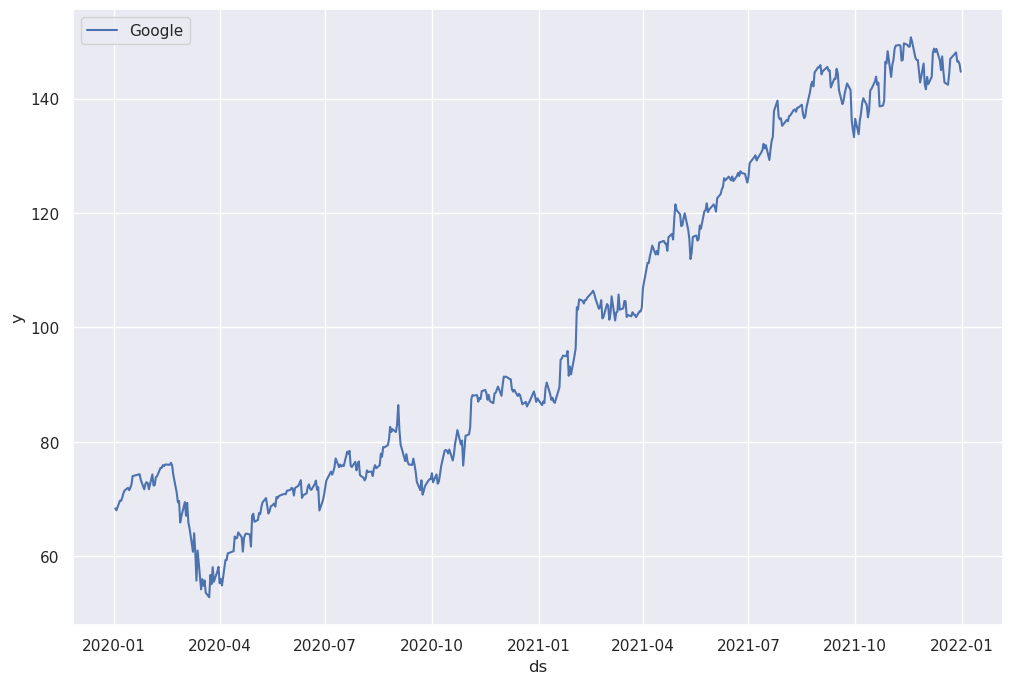

In [19]:
#--------------------------------------------#
# Step 1: Install and Import Libraries
#--------------------------------------------#

# Install libraries
!pip install yfinance prophet

# Data processing
import pandas as pd
import numpy as np

# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Hyperparameter tuning
import itertools
from prophet.diagnostics import cross_validation, performance_metrics

#--------------------------------------------#
# Step 2: Pull Data
#--------------------------------------------#

# Data start date
start_date = '2020-01-02'

# Data end date
end_date = '2022-01-01' # yfinance excludes the end date, so we need to add one day to the last day of data

# Pull close data from Yahoo Finance for the list of tickers
ticker_list = ['GOOG']
data = yf.download(ticker_list, start=start_date, end=end_date)[['Close']]

# Change column names
data = data.reset_index()
data.columns = ['ds', 'y']

# Take a look at the data
data.head()

# Data information
data.info()

# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data['ds'], y=data['y'])
plt.legend(['Google'])

#--------------------------------------------#
# Step 3: Baseline Model Using Default Hyperparameters
#--------------------------------------------#

# Initiate the model
baseline_model = Prophet()

# Fit the model on the training dataset
baseline_model.fit(data)

# Cross validation
baseline_model_cv = cross_validation(model=baseline_model, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")
baseline_model_cv.head()

# Model performance metrics
baseline_model_p = performance_metrics(baseline_model_cv, rolling_window=1)
baseline_model_p.head()

# Get the performance value
baseline_model_p['mape'].values[0]

#--------------------------------------------#
# Step 4: Models with Manual Hyperparameter Changes
#--------------------------------------------#

# Initiate the model
manual_model = Prophet(changepoint_range=0.9)

# Fit the model on the training dataset
manual_model.fit(data)

# Cross validation
manual_model_cv = cross_validation(manual_model, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")

# Model performance metrics
manual_model_p = performance_metrics(manual_model_cv, rolling_window=1)
manual_model_p['mape'].values[0]

# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

# Take a look at the events data
events

# Add special events
manual_model = Prophet(holidays=events)

# Fit the model on the training dataset
manual_model.fit(data)

# Cross validation
manual_model_cv = cross_validation(manual_model, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")

# Model performance metrics
manual_model_p = performance_metrics(manual_model_cv, rolling_window=1)
manual_model_p['mape'].values[0]

#--------------------------------------------#
# Step 5: Automatic Hyperparameter Tuning
#--------------------------------------------#

# Set up parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Create a list to store MAPE values for each combination
mapes = []

# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(data)
    # Cross-validation
    df_cv = cross_validation(m, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])

# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes

# Find the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)

# Fit the model using the best parameters
auto_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'],
                     seasonality_prior_scale=best_params['seasonality_prior_scale'],
                     seasonality_mode=best_params['seasonality_mode'])

# Fit the model on the training dataset
auto_model.fit(data)

# Cross validation
auto_model_cv = cross_validation(auto_model, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")

# Model performance metrics
auto_model_p = performance_metrics(auto_model_cv, rolling_window=1)

auto_model_p['mape'].values[0]

#--------------------------------------------#
# Step 6: Automatic Hyperparameter Tuning using Log Data
#--------------------------------------------#

# Create a copy of the data
data_log = data.copy()

# Create the log scale data by taking the natual log of the stock prices.
data_log['y_log'] = np.log(data['y'])

# Delete the stock price and rename the log scale stock price to y
data_log = data_log.drop('y', axis=1).rename(columns={'y_log': 'y'})

# Take a look at the data
data_log.head()

# Parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1.0, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Store the MAPEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(data_log)
    # Cross-validation
    df_cv = cross_validation(m, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])

# Tuning results
best_params = all_params[np.argmin(mapes)]

# Best parameters
print(best_params)

# Train model using best parameters
auto_model_log = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'],
                     seasonality_prior_scale=best_params['seasonality_prior_scale'],
                     seasonality_mode=best_params['seasonality_mode'])

# Fit the model on the training dataset
auto_model_log.fit(data_log)

# Cross validation
auto_model_log_cv = cross_validation(auto_model_log, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")

# Model performance metrics
auto_model_log_p = performance_metrics(auto_model_log_cv, rolling_window=1)
auto_model_log_p['mape'].values[0]
